# Project 4: Graph Algorithms

## Part 1: Stock Market


In [1]:
library(igraph)
# library(clevr)


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union



In [18]:
ticker_sector = read.csv("finance_data/Name_sector.csv", header=TRUE, stringsAsFactors=FALSE)
print(sprintf("Number of companies in the ticker list is %s", nrow(ticker_sector)))
sectors = unique(ticker_sector[,2])
print(sprintf("Number of unique sectors: %s", length(sectors)))
palette = rainbow(length(sectors), s = 0.8, v = 1)

[1] "Number of companies in the ticker list is 505"
[1] "Number of unique sectors: 11"


## Daily

In [3]:
filenames = list.files("finance_data/data/", pattern="*.csv")
filenames = paste("finance_data/data", filenames, sep="/")
comp_null_d = c()
log_return_d = matrix(0, length(filenames), 764)
for (i in c(1:length(filenames))) {
    comp_data = read.csv(filenames[i], header=TRUE, stringsAsFactors=FALSE)
    if (dim(comp_data)[1] != 765) {
        comp_null_d = append(comp_null_d, i)        
    } else {
        p = comp_data[, 5] 
        q = c()
        r = c()
        for(t in c(2:length(p))){
            q[t-1] = (p[t] - p[t-1]) / p[t-1]
        }
        r = log(1+q)
        log_return_d[i,] = r
    }
}
ticker_sector_d = ticker_sector[-comp_null_d,]
log_return_d = log_return_d[-comp_null_d,]
print(sprintf("Number of companies in the ticker list with missing data: %s", length(comp_null_d)))

[1] "Number of companies in the ticker list with missing data: 11"


In [7]:
generate_correlation = function(edge_file, log_return, ticker_sector) {
    cat("start", "\t", "end", "\t", "weight", file=edge_file)
    num_comp = dim(log_return)[1]
    for(i in c(1:(num_comp-1))){
        for(j in c((i+1):num_comp)){
            r_i = mean(log_return[i,])
            r_j = mean(log_return[j,])
            r_ij = mean(log_return[i,] * log_return[j,])
            r_i_squared = log_return[i,]^2
            r_j_squared = log_return[j,]^2
            p_ij = (r_ij - (r_i * r_j)) / (sqrt((mean(r_i_squared)-(r_i^2)) * (mean(r_j_squared)-(r_j^2))))
            w_ij = sqrt(2 * (1-p_ij))
            cat('\n', ticker_sector[i, 1], '\t', ticker_sector[j, 1], '\t', w_ij, file=edge_file)
        }
    }
}

In [11]:
edge_file_d <- file("finance_data/edges_date.txt", "w")
generate_correlation(edge_file_d, log_return_d, ticker_sector_d)
close(edge_file_d)

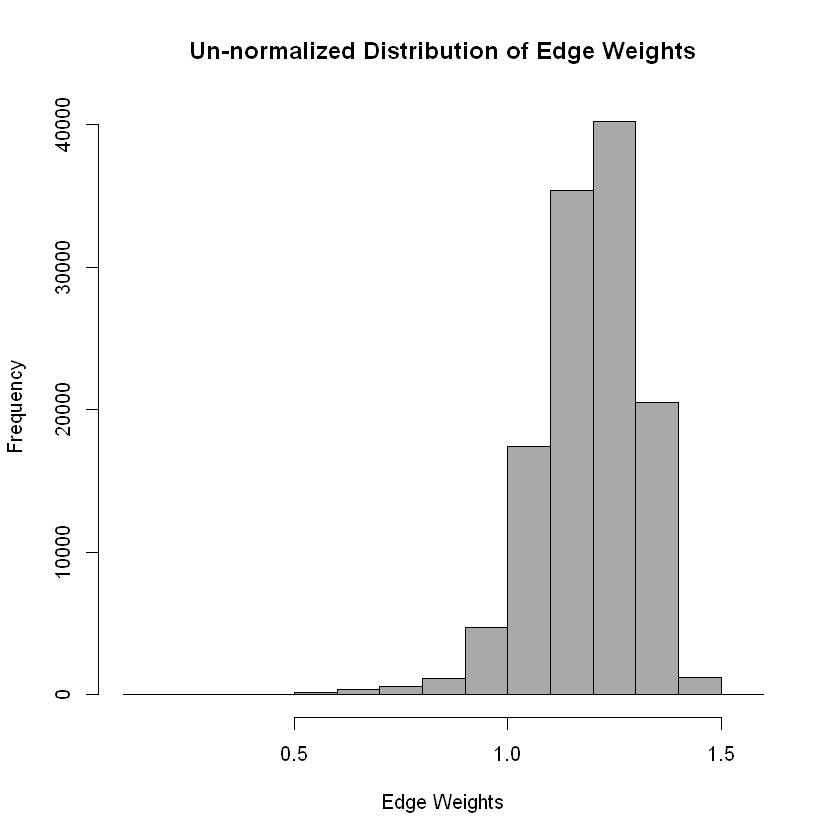

In [14]:
edge_list_d = read.delim("finance_data/edges_date.txt", header=TRUE)
g_d = graph.data.frame(edge_list_d, directed = FALSE)
E(g_d)$weight = edge_list_d[,"weight"]
hist(E(g_d)$weight, col="darkgrey", main="Un-normalized Distribution of Edge Weights", 
     xlab="Edge Weights", ylab="Frequency")

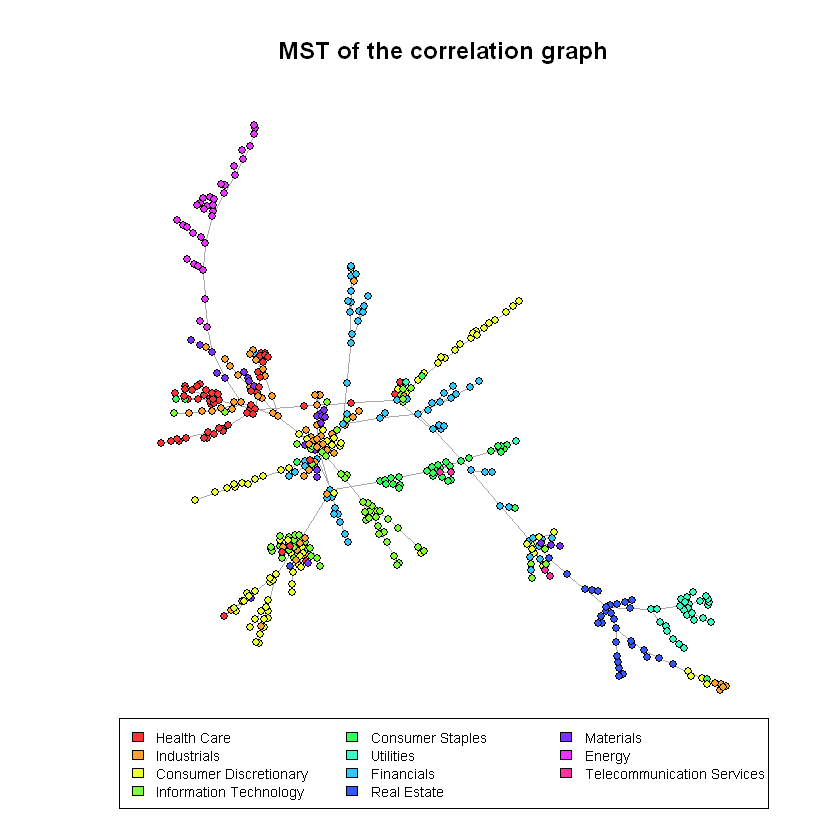

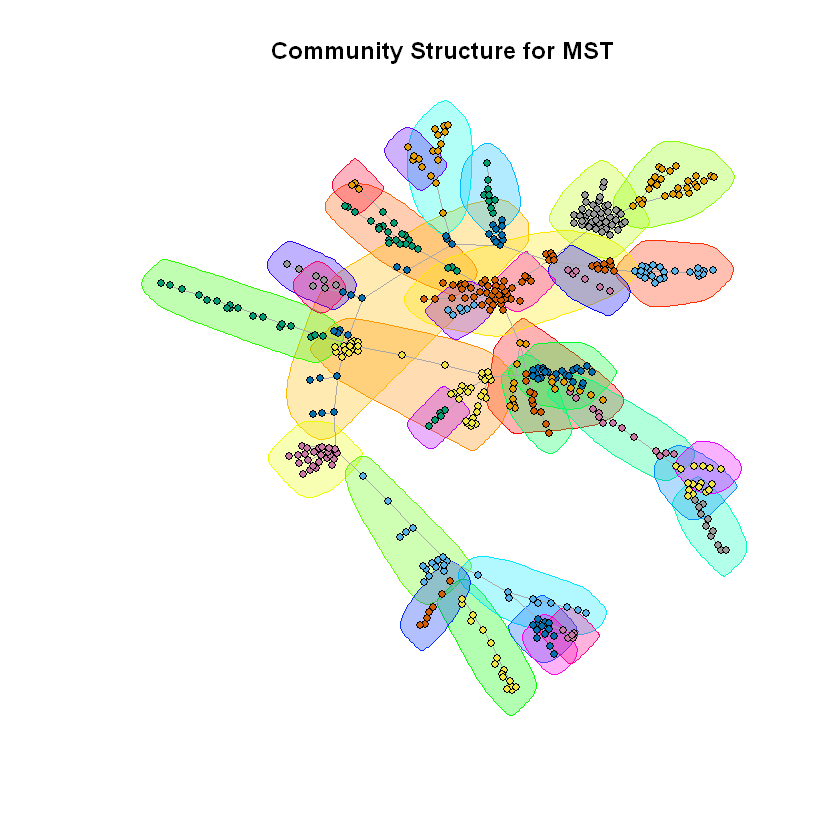

In [23]:
sector_index_d = c()
for(v in c(1:vcount(g_d))) {
    sector_index_d = append(sector_index_d, which(sectors == ticker_sector_d[v, 2]))
}
mst_d = mst(g_d, algorithm="prim")
plot(mst_d, vertex.size=3, vertex.label=NA, vertex.color=palette[sector_index_d])
legend(x=-1.15, y=-1.1, legend=sectors, fill=palette, ncol=3, cex=0.7)
par(xpd=TRUE)
title("MST of the correlation graph")

clusters = cluster_walktrap(mst_d)
plot(mst_d, mark.groups=clusters, edge.width=0.5,
     vertex.size=3, vertex.color=clusters$membership, vertex.label="",
     main="Community Structure for MST")

In [24]:
calculate_metrics = function(g, log_return, ticker_sector) {
    S_i = c()
    for(i in c(1:length(sectors))){
        S_i[i] = length(which(sectors[i] == ticker_sector[,2]))
    }

    p_method_1 = c()
    p_method_2 = c()
    for(v in c(1:vcount(g))){
        neighbors = neighbors(g, v)
        N_i = length(neighbors)
        Q_i = 0
        for(i in neighbors){
            if(ticker_sector[i,2] == ticker_sector[v,2])
                Q_i = Q_i+1
        }
        p_method_1[v] = Q_i / N_i
        p_method_2[v] = S_i[which(sectors == ticker_sector[v, 2])] / vcount(g)
    }
    alpha_1 = sum(p_method_1) / vcount(g)
    print(sprintf("Alpha value for method 1 is: %s", alpha_1))
    alpha_2 = sum(p_method_2) / vcount(g)
    print(sprintf("Alpha value for method 2 is: %s", alpha_2))
}

In [27]:
calculate_metrics(mst_d, log_return_d, ticker_sector_d)

[1] "Alpha value for method 1 is: 0.828930077530676"
[1] "Alpha value for method 2 is: 0.114188070612533"


## Weekly

In [30]:
comp_null_w = c()
log_return_w = matrix(0, length(filenames), 142)
for (i in c(1:length(filenames))) {
    comp_data = read.csv(filenames[i], header=TRUE, stringsAsFactors=FALSE)
    comp_data["Day"] = weekdays(as.Date(comp_data[,1])) 
    comp_data = subset(comp_data, Day == 'Monday')
    if (dim(comp_data)[1] != 143) {
        comp_null_w = append(comp_null_w, i)        
    } else {
        p = comp_data[, 5] 
        q = c()
        r = c()
        for(t in c(2:length(p))){
            q[t-1] = (p[t] - p[t-1]) / p[t-1]
        }
        r = log(1+q)
        log_return_w[i,] = r
    }
}
ticker_sector_w = ticker_sector[-comp_null_w,]
log_return_w = log_return_w[-comp_null_w,]
print(sprintf("Number of companies in the ticker list with missing data: %s", length(comp_null_w)))

[1] "Number of companies in the ticker list with missing data: 13"


In [32]:
edge_file_w <- file("finance_data/edges_week.txt", "w")
generate_correlation(edge_file_w, log_return_w, ticker_sector_w)
close(edge_file_w)

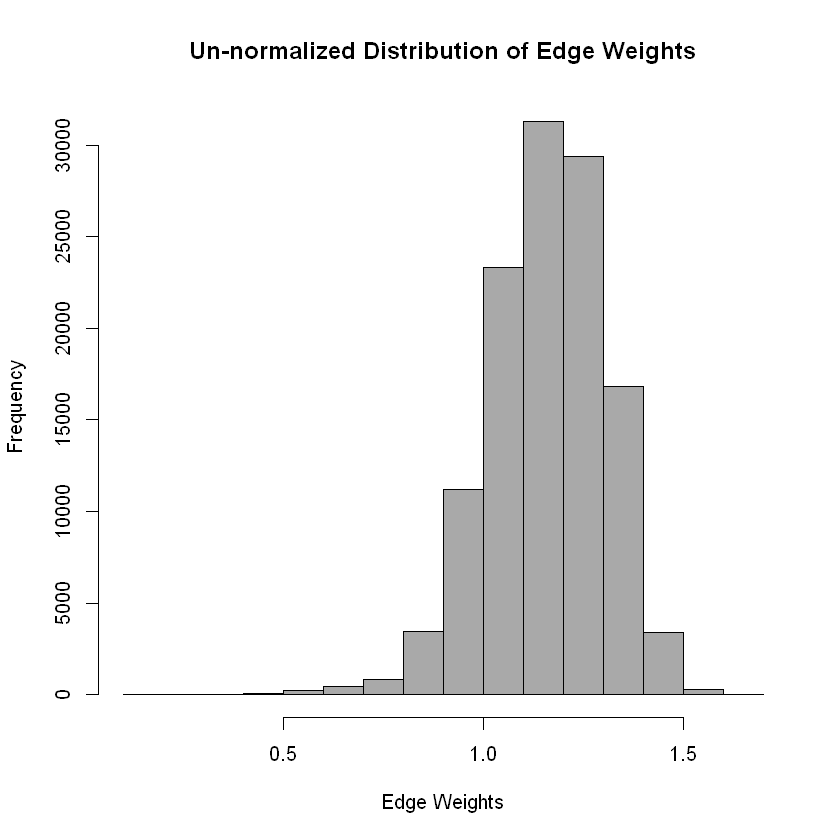

In [33]:
edge_list_w = read.delim("finance_data/edges_week.txt", header=TRUE)
g_w = graph.data.frame(edge_list_w, directed = FALSE)
E(g_w)$weight = edge_list_w[,"weight"]
hist(E(g_w)$weight, col="darkgrey", main="Un-normalized Distribution of Edge Weights", 
     xlab="Edge Weights", ylab="Frequency")

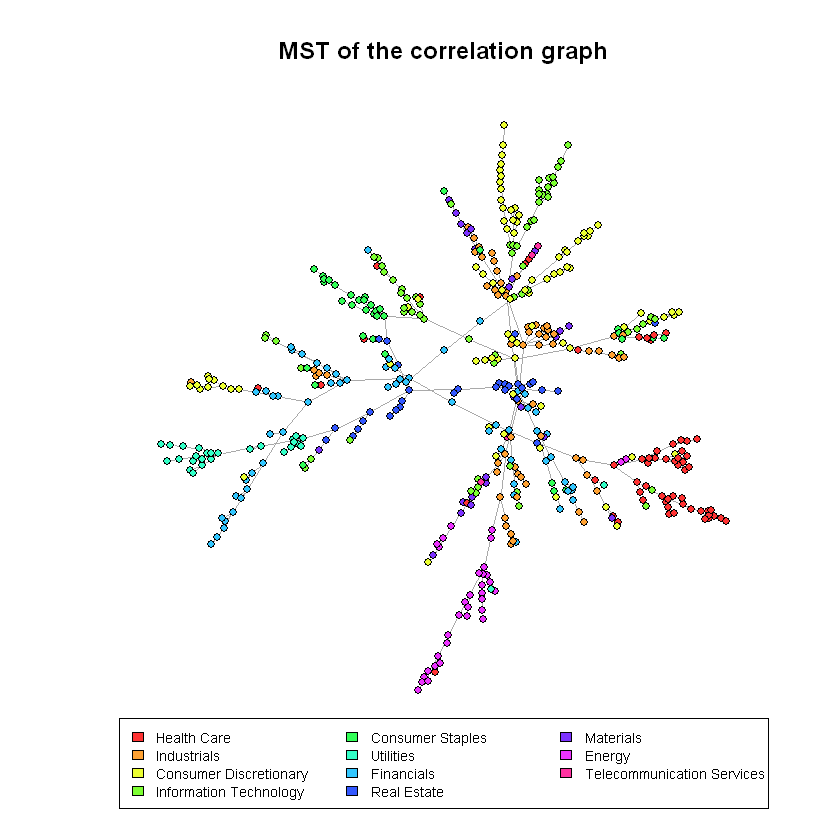

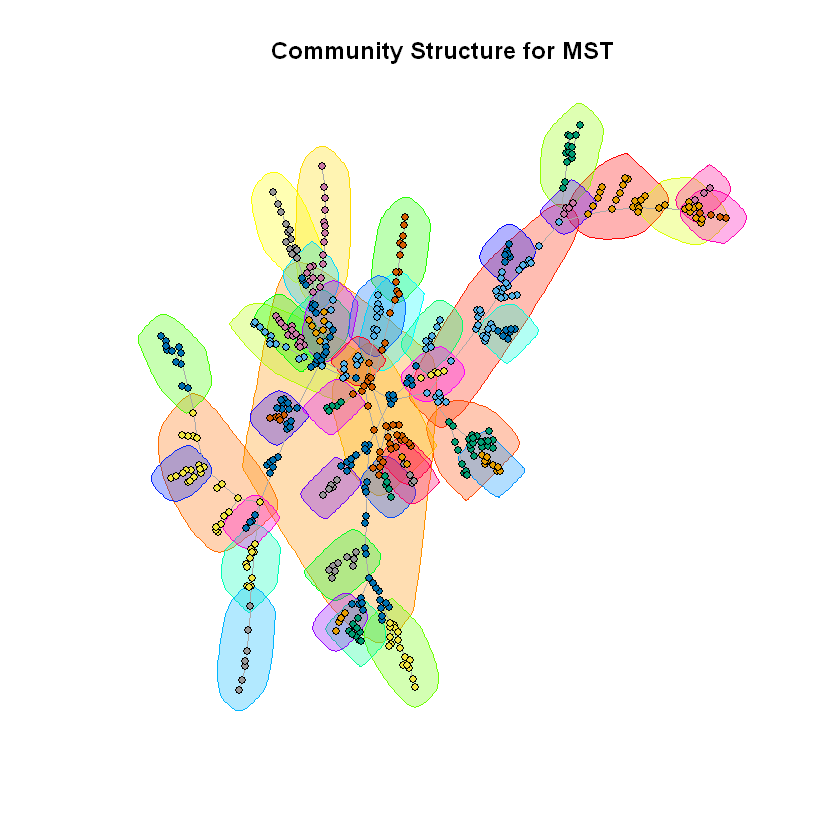

In [34]:
sector_index_w = c()
for(v in c(1:vcount(g_w))) {
    sector_index_w = append(sector_index_w, which(sectors == ticker_sector_w[v, 2]))
}
mst_w = mst(g_w, algorithm="prim")
plot(mst_w, vertex.size=3, vertex.label=NA, vertex.color=palette[sector_index_w])
legend(x=-1.15, y=-1.1, legend=sectors, fill=palette, ncol=3, cex=0.7)
par(xpd=TRUE)
title("MST of the correlation graph")

clusters = cluster_walktrap(mst_w)
plot(mst_w, mark.groups=clusters, edge.width=0.5,
     vertex.size=3, vertex.color=clusters$membership, vertex.label="",
     main="Community Structure for MST")

In [35]:
calculate_metrics(mst_w, log_return_w, ticker_sector_w)

[1] "Alpha value for method 1 is: 0.743957284810943"
[1] "Alpha value for method 2 is: 0.114308612598321"


## Monthly

In [83]:
comp_null_m = c()
log_return_m = matrix(0, length(filenames), 24)
for (i in c(1:length(filenames))) {
    comp_data = read.csv(filenames[i], header=TRUE, stringsAsFactors=FALSE)
    comp_data["Day"] = format(as.Date(comp_data[,1]), format="%d")
    comp_data = subset(comp_data, Day == '15')
    if (dim(comp_data)[1] != 25) {
        comp_null_m = append(comp_null_m, i)        
    } else {
        p = comp_data[, 5] 
        q = c()
        r = c()
        for(t in c(2:length(p))){
            q[t-1] = (p[t] - p[t-1]) / p[t-1]
        }
        r = log(1+q)
        log_return_m[i,] = r
    }
}
ticker_sector_m = ticker_sector[-comp_null_m,]
log_return_m = log_return_m[-comp_null_m,]
print(sprintf("Number of companies in the ticker list with missing data: %s", length(comp_null_m)))

[1] "Number of companies in the ticker list with missing data: 13"


In [84]:
edge_file_m <- file("finance_data/edges_month.txt", "w")
generate_correlation(edge_file_m, log_return_m, ticker_sector_m)
close(edge_file_m)

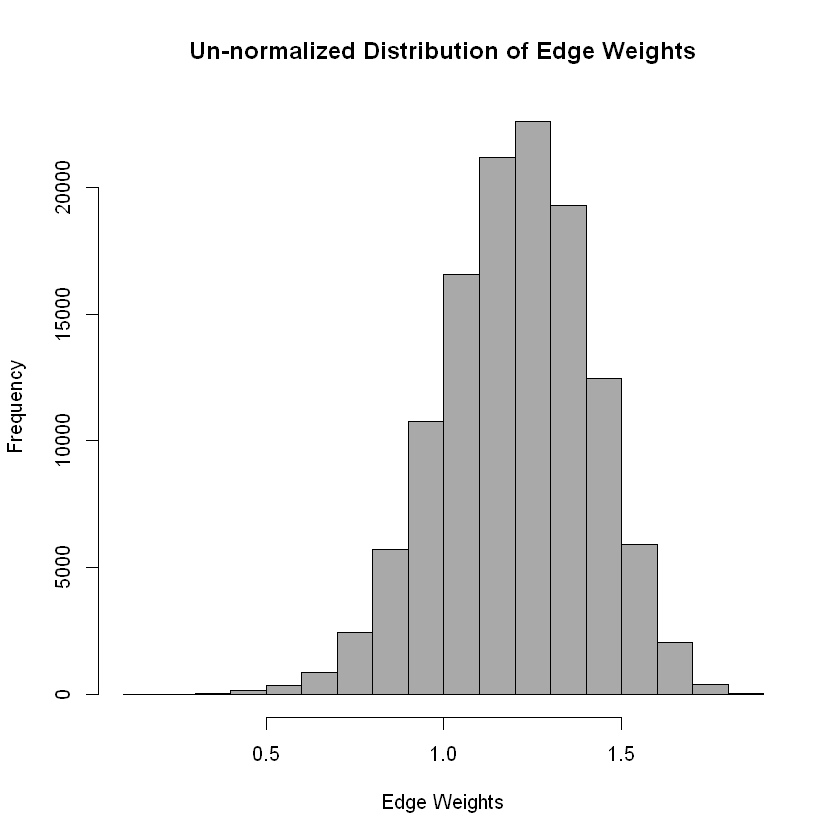

In [85]:
edge_list_m = read.delim("finance_data/edges_month.txt", header=TRUE)
g_m = graph.data.frame(edge_list_m, directed = FALSE)
E(g_m)$weight = edge_list_m[,"weight"]
hist(E(g_m)$weight, col="darkgrey", main="Un-normalized Distribution of Edge Weights", 
     xlab="Edge Weights", ylab="Frequency")

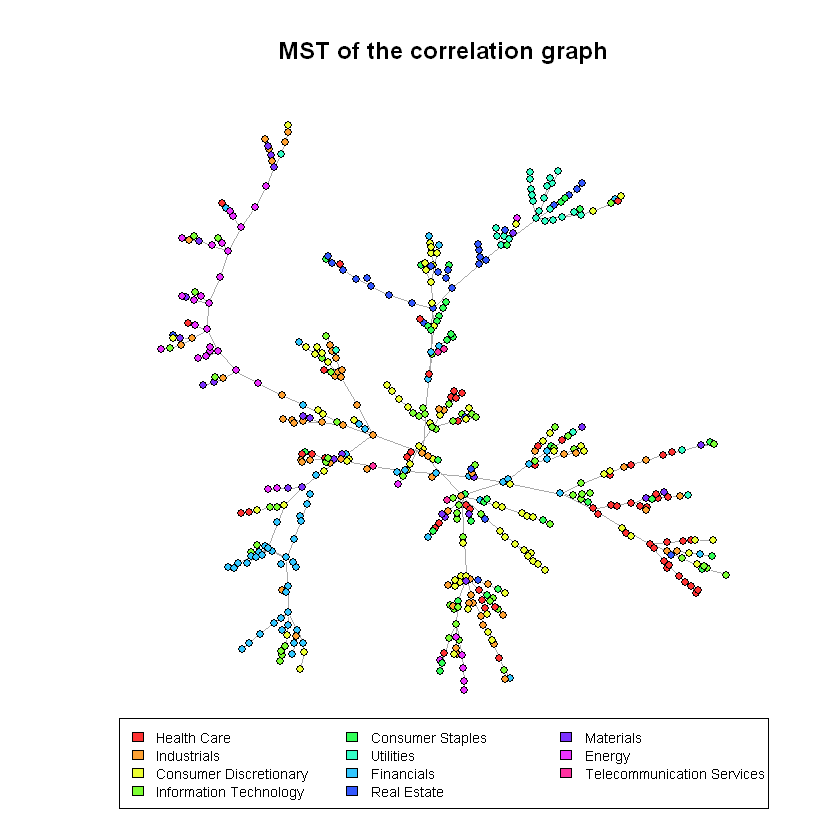

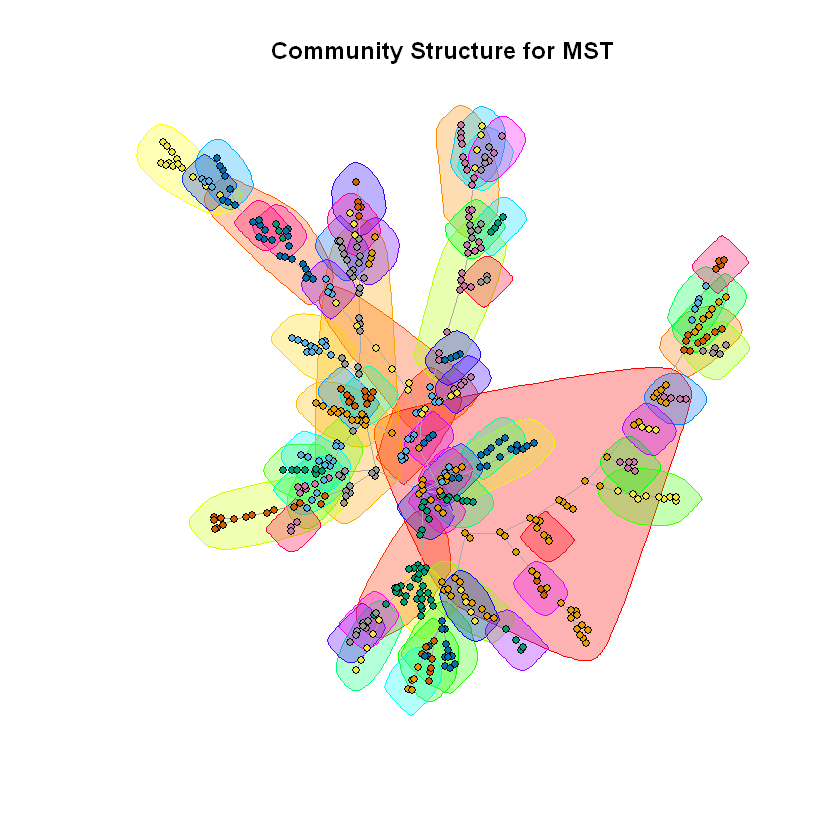

In [86]:
sector_index_m = c()
for(v in c(1:vcount(g_m))) {
    sector_index_m = append(sector_index_m, which(sectors == ticker_sector_m[v, 2]))
}
mst_m = mst(g_m, algorithm="prim")
plot(mst_m, vertex.size=3, vertex.label=NA, vertex.color=palette[sector_index_m])
legend(x=-1.15, y=-1.1, legend=sectors, fill=palette, ncol=3, cex=0.7)
par(xpd=TRUE)
title("MST of the correlation graph")

clusters = cluster_walktrap(mst_m)
plot(mst_m, mark.groups=clusters, edge.width=0.5,
     vertex.size=3, vertex.color=clusters$membership, vertex.label="",
     main="Community Structure for MST")

In [87]:
calculate_metrics(mst_m, log_return_m, ticker_sector_m)

[1] "Alpha value for method 1 is: 0.484446380178087"
[1] "Alpha value for method 2 is: 0.114308612598321"
